In [1]:
############## Bath parameters ##############
global Boltzmann, hbar, Temp
Boltzmann = 1.0
hbar = 1.0

Temp = 1  # changeable

# functions from test_baths.py
from test_baths import (
    spectral_density_func_paper,
    Power_spectrum_func_paper,
)
from concurrent.futures import ProcessPoolExecutor, as_completed
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap
import matplotlib.pyplot as plt
from qutip import *
import numpy as np
import itertools
import os

# Import the outsourced plot settings
from plot_settings import *

In [ ]:
# =============================
# SYSTEM PARAMETERS     (**changeable**)
# =============================
global N_atoms, Coupled, ODE_Solver, omega_laser, E0, E_freqs, E_amps, omega_A, mu_A, rabi_0, delta, theta, J, RWA_laser, time_cut
time_cut = None # time after which the evolution becomes unphysical, to be decided in check_the_solver
# CAN ONLY HANDLE 2 ATOMS for MY solver
N_atoms = 2  # Set the number of atoms only works for 2

fac_two_pi = 1 * 2 * np.pi  # Factor to convert from Hertz to angular frequency [fs^-1] -> [rads/ fs] -> also have to adjust the plotting of the 2D spectrum
RWA_laser = True  #  CAN ONLY HANDLE TRUE For MY solver (paper)        only valid for omega_laser ~ omega_A ~ omega_B
Coupled = False  # Set coupling condition
ODE_Solver = "MY"  # Choose between "BR" (Bloch-Redfield) or "ME" (Master Equation) or "MY" (solve the EOMs from the paper)


### Phase Cycling for Averaging
phases = [k * np.pi / 2 for k in range(4)]


### Define Atomic States
atom_g, atom_e = basis(2, 0), basis(2, 1)  # Ground, Excited states


### define the laser parameters
omega_laser = (
    fac_two_pi * 0.48
)  #  omega = 2 pi c nu_tilde: [fs⁻¹] = 2 pi 3* 10^10 cm/ (10^15 fs) nu_tilde = 6 pi /(10^5) * 16000 cm-1 / in the middle of the two transitions
E_freqs = [omega_laser] * 3  # Laser frequencies
E0 = 0.1  # (**changeable*) Amplitude of the laser field -> excitation should be <=1%!!!
E_amps = [E0, E0, 1e-1 * E0]  # third one is small to simulate a probe field


### Coupling to the bath
# Linblad Case # TODO DONT KNOW HOW TO CONNECT THIS TO THE PAPER!!
gamma_phi = 1e-1  # (**changeable**):  Dephasing rate with MESOLVE


### Functions to calculate the diagonal hamiltonian of the
def Hamilton_dimer_sys(hbar, omega_A, omega_B, J):
    H = hbar * (
        omega_A * ket2dm(tensor(atom_e, atom_g))
        + omega_B * ket2dm(tensor(atom_g, atom_e))
        + J
        * (
            tensor(atom_e, atom_g) * tensor(atom_g, atom_e).dag()
            + tensor(atom_g, atom_e) * tensor(atom_e, atom_g).dag()
        )
        + (omega_A + omega_B) * ket2dm(tensor(atom_e, atom_e))
    )
    return H


def calc_mu(H, mu_A, mu_B, theta):
    eigenvecs = H.eigenstates()[1]
    mu_10 = -mu_A * np.sin(theta) + mu_B * np.cos(theta)
    sigma_m_10 = mu_10 * (eigenvecs[0] * eigenvecs[1].dag()).unit()

    mu_20 = mu_A * np.cos(theta) + mu_B * np.sin(theta)
    mu_31 = -mu_B * np.sin(theta) + mu_A * np.cos(theta)
    mu_32 = mu_B * np.cos(theta) + mu_A * np.sin(theta)

    sigma_m_20 = mu_20 * (eigenvecs[0] * eigenvecs[2].dag()).unit()
    sigma_m_32 = mu_31 * (eigenvecs[1] * eigenvecs[3].dag()).unit()
    sigma_m_31 = mu_32 * (eigenvecs[2] * eigenvecs[3].dag()).unit()

    return [sigma_m_10, sigma_m_20, sigma_m_31, sigma_m_32]


psi_ini = ket2dm(tensor(atom_g, atom_g))  # initial state

pulse_duration = 5  # fs

### If the excited states are coupled -> modify the energy levels
if Coupled:
    J = 0.009 * fac_two_pi  # fac_two_pi * c * 300 cm-1
    omega_A = fac_two_pi * 0.486  # fac_two_pi * c * 16200 cm-1
    omega_B = fac_two_pi * 0.474  # fac_two_pi * c * 15800 cm-1
    mu_A = 1
    mu_B = -0.23
else:
    J = 0.0
    omega_A = 0.4908 * fac_two_pi # fac_two_pi * c * 16360 cm-1
    omega_B = 0.4692 * fac_two_pi #fac_two_pi * c * 15640 cm-1
    mu_A = 1
    mu_B = 1 * mu_A


cutoff = 1e1 * omega_A  # cutoff frequency for the bath
args_paper = {
    "g": np.sqrt(gamma_phi * cutoff),
    "cutoff": cutoff,
    "Boltzmann": Boltzmann,
    "hbar": hbar,
    "Temp": Temp,
}

theta = np.arctan(2 * J / (omega_A - omega_B)) / 2

H0 = Hamilton_dimer_sys(hbar, omega_A, omega_B, J)

print("Dipole moments: ", mu_A, mu_B)
print("Coupling constants: ", J)
print("Coupling angles: ", theta)

# OLD
# eigenenergies, eigenstates = H0.eigenstates()
# sm_list = calc_mu(H0, mu_A, mu_B, theta)

### NEW: ANALYTIC DIAGONALIZATION OF THE HAMILTONIAN; LIKE IN THE PAPER
eigenenergy_1 = 1 / 2 * (omega_A + omega_B) - 1 / 2 * np.sqrt(
    (omega_A - omega_B) ** 2 + 4 * J**2
)
eigenenergy_2 = 1 / 2 * (omega_A + omega_B) + 1 / 2 * np.sqrt(
    (omega_A - omega_B) ** 2 + 4 * J**2
)
eigenenergy_3 = omega_A + omega_B
eigenenergies = [0, eigenenergy_1, eigenenergy_2, eigenenergy_3]

C_A_1 = -np.sin(theta)
C_A_2 = np.cos(theta)
C_B_1 = C_A_2
C_B_2 = -C_A_1

eigenvecs = [
    tensor(atom_g, atom_g),
    C_A_1 * tensor(atom_e, atom_g) + C_B_1 * tensor(atom_g, atom_e),
    C_A_2 * tensor(atom_e, atom_g) + C_B_2 * tensor(atom_g, atom_e),
    tensor(atom_e, atom_e),
]

mu_10 = mu_A * C_A_1 + mu_B * C_A_2
mu_20 = mu_A * C_B_1 + mu_B * C_B_2
mu_31 = mu_B * C_A_1 + mu_A * C_B_1
mu_32 = mu_B * C_B_1 + mu_A * C_B_2

sm_list = [
    mu_10 * (eigenvecs[0] * eigenvecs[1].dag()).unit(),
    mu_20 * (eigenvecs[0] * eigenvecs[2].dag()).unit(),
    mu_31 * (eigenvecs[1] * eigenvecs[3].dag()).unit(),
    mu_32 * (eigenvecs[2] * eigenvecs[3].dag()).unit(),
]
SM_op = sum(sm_list)
Dip_op = SM_op + SM_op.dag()

print("Eigenenergies: ", eigenenergies)
print("Dipole moments: ", [sm.norm() for sm in sm_list])


# Coupling to the environment
cplng_ops_to_env = [
    ket2dm(tensor(atom_e, atom_g)),
    ket2dm(tensor(atom_g, atom_e)),
    ket2dm(tensor(atom_e, atom_e)),
]

Deph_op = sum(cplng_ops_to_env)
env = BosonicEnvironment.from_spectral_density(
    lambda w: spectral_density_func_paper(w, args_paper), wMax=10 * cutoff, T=Temp
)
a_ops_list = [
    [
        cplng_ops_to_env[0],
        env.power_spectrum,
    ],  # atom A with ohmic_spectrum
    [
        cplng_ops_to_env[1],
        env.power_spectrum,
    ],  # atom B with ohmic_spectrum
    [
        cplng_ops_to_env[2],
        lambda w: env.power_spectrum(2 * w),
    ],  # double excited state with 2 * ohmic_spectrum
]

c_ops_list = [np.sqrt(gamma_phi) * Deph_op]
e_ops_list = [
    ket2dm(tensor(atom_g, atom_g)),
    ket2dm(tensor(atom_e, atom_g)),
    ket2dm(tensor(atom_g, atom_e)),
    ket2dm(tensor(atom_e, atom_e)),
#    ket2dm(state) for state in eigenvecs
]  # [ket2dm(state) for state in eigenvecs]
e_ops_labels = ["0", "A", "B", "AB"]#[f"|{i}" + r"$\rangle$" for i in range(len(eigenvecs))]


# Rabi oscillation things / coupling to the laser
g_value = (mu_A * mu_B) * E0  # TODO check.  this might lead to a uncorrect rabi period
rabi_0 = g_value / hbar
rabi_gen = np.sqrt(
    rabi_0**2
)  # Not really the rabi freq, because i dont really take detuning into account, because i have 2 atoms


t_max_L = 6 * 2 * np.pi / omega_laser  # Just the six periods of the laser rotation
t_prd = 2 * np.pi / rabi_gen
t_max_r = max(100, 0.05 * t_prd)  # (**changeable**) # 5 periods of the rabi oscillation
t_max = t_max_r
fine_spacing = 0.1 * min(t_prd, pulse_duration)
Delta_ts = [pulse_duration / 2] * 3
print("Period for one Rabi oscillation: T/fs  = ", t_prd)


0.03083787348763741
Dipole moments:  1 1
Coupling constants:  0.0
Coupling angles:  0.0
Eigenenergies:  [0, np.float64(2.948070546128662), np.float64(3.0837873487637406), 6.031857894892402]
Dipole moments:  [1.0, 1.0, 1.0, 1.0]
Period for one Rabi oscillation: T/fs  =  62.83185307179586


In [20]:
def apply_RWA_phase_factors(rho, omega, t):
    """
    Apply time-dependent phase factors to the density matrix entries.

    Parameters:
        rho (Qobj): Density matrix (Qobj) to modify.
        omega (float): Frequency of the phase factor.
        t (float): Current time.

    Returns:
        Qobj: Modified density matrix with phase factors applied.
    """
    # Extract the density matrix as a NumPy array
    rho_array = rho.full()
    # print(rho.isherm)

    # Apply the phase factors to the specified elements
    phase_1 = np.exp(-1j * omega * t)  # e^(-i * omega * t)
    phase_2 = np.exp(-1j * 2 * omega * t)  # e^(-i * 2 * omega * t)

    # Modify the elements
    bar_alpha = 3
    for alpha in range(1, 3):
        rho_array[alpha, 0] *= phase_1  # rho_alpha_0 = sigma_alpha_0 * e^(-i * omega * t)
        rho_array[0, alpha] *= np.conj(phase_1)

        rho_array[bar_alpha, alpha] *= phase_1  # rho_bar_alpha_alpha = sigma_bar_alpha_alpha * e^(-i * omega * t)
        rho_array[alpha, bar_alpha] *= np.conj(phase_1)

    rho_array[bar_alpha, 0] *= phase_2  # rho_bar_alpha_0 = sigma_bar_alpha_0 * e^(-i * 2 * omega * t)
    rho_array[0, bar_alpha] *= np.conj(phase_2)

    rho_result = Qobj(rho_array, dims=rho.dims)
    # print(rho_array[0, 1], rho_array[1,0])

    #assert rho_result.isherm, "The resulting density matrix is not Hermitian."

    return rho_result

print(rho_f.isherm)

ones_matrix = np.ones((4, 4))
rho_test = rho_1 # Qobj(ones_matrix)
# print("rho_test before: ", rho_test)
rho_modified = apply_RWA_phase_factors(rho_test, omega_laser, 0.1)
print("after RWA: ", rho_modified)






t=1
phase_1 = np.exp(-1j * omega_laser * t)  # e^(-i * omega * t)

np.angle(phase_1), np.angle(np.conj(phase_1))

np.angle(rho_f.full()[0,1]), np.angle(rho_f.full()[1, 0])
rho_matrix = rho_1.full()
rho_1




# vizualize
test_args = get_pulse_args(0, 0, 0)

L = Liouville(test_args)  # what is this?
L
L_matrix = L(0)  # Get the operator at time t=0
print(L_matrix)
from qutip.visualization import matrix_histogram
matrix_histogram(L(0))

False


NameError: name 'rho_1' is not defined

In [23]:
# =============================
# MORE FUNCTIONS
# =============================
def check_the_solver(psi_ini, times, e_ops_list):
    """
    Checks the solver within the compute_pulse_evolution function
    with the provided psi_ini, times, and e_ops_list.

    Parameters:
        psi_ini (qutip.Qobj): Initial quantum state.
        times (numpy.ndarray): Time array for the evolution.
        e_ops_list (list of qutip.Qobj): List of expectation value operators.

    Returns:
        None: Prints the results of the checks.  Raises exceptions on errors.
    """
    print(f"Checking '{ODE_Solver}' solver ")

    # 1. Input Validation
    # ----------------------
    if not isinstance(psi_ini, qutip.Qobj):
        raise TypeError("psi_ini must be a qutip.Qobj")
    if not isinstance(times, np.ndarray):
        raise TypeError("times must be a numpy.ndarray")
    if not isinstance(e_ops_list, list) or not all(isinstance(op, qutip.Qobj) for op in e_ops_list):
        raise TypeError("e_ops_list must be a list of qutip.Qobj")

    if len(times) < 2:
        raise ValueError("times must have at least two elements")

    # 2. Set up the solver call
    # ---------------------------------------
    i = 0  # Example pulse index
    phi = 0.0  # Example phase

    # 3. Call the function to be checked
    # ----------------------------------
    result = compute_pulse_evolution(psi_ini, times, phi, i)

    # 4. Check the result (basic checks)
    # ----------------------------------
    if not isinstance(result, qutip.Result):
        raise TypeError("Result must be a qutip.Result object")

    # Add more specific checks as needed for your implementation
    if result.times != list(times):
        raise ValueError("Result times do not match input times")

    if len(result.states) != len(times):
        raise ValueError("Number of output states does not match number of time points")

    if len(result.expect) != len(e_ops_list):
        raise ValueError("Number of expectation value lists does not match number of e_ops")
    
    # 5. Check if density matrix is Hermitian, positive, and trace-preserving
    # ------------------------------------------------------
    for index, state in enumerate(result.states):
        strg = ""
        time = times[index]
        if not state.isherm:
            strg += f"Density matrix is not Hermitian after t = {time}.\n"
        eigvals = state.eigenenergies()
        #print(eigvals)
        if not np.all(eigvals >= -1e-9):  # allow for small numerical negative eigenvalues
            strg += f"Density matrix is not positive semidefinite after t = {time}: The lowest eigenvalue is {eigvals.min()}.\n"
            time_cut = time
        if not np.isclose(state.tr(), 1.0):
            strg += f"Density matrix is not trace-preserving after t = {time}: The trace is {state.tr()}.\n "
            time_cut = time
        if strg:
            strg += "Adjust your parameters!"
            print(strg) # raise ValueError(strg)
            break

    else: print("Checks passed. solver appears to be called correctly, and density matrix remains Hermitian and positive.")

    return result


def plot_positive_color_map(
    datas,
    T_wait=np.inf,
    space="real",
    type="real",
    positive=False,
    safe=False,
    output_dir=None,
    ODE_Solver=None,
):
    """
    Create a color plot of 2D functional data for positive x and y values only.

    Parameters:
        datas (tuple): Tuple containing (x, y, data) where x and y are 1D arrays and data is a 2D array.
        T_wait (float): waiting time to include in plot title and file name.
        space (str): Either 'real' or 'freq' specifying the space of the data.
        type (str): Type of data ('real', 'imag', 'abs', or 'phase'). Used only if space="freq".
        positive (bool): Whether to use ONLY positive values of x and y.
        safe (bool): If True, saves the plot to a file.
        output_dir (str, optional): Directory to save the plot.

    Returns:
        None
    """
    # Ensure datas is a tuple with (x, y, data)
    if not isinstance(datas, tuple) or len(datas) != 3:
        raise ValueError("datas must be a tuple of (x, y, data)")

    x, y, data = datas

    # Validate that x, y, and data are numpy arrays
    x = np.array(x)
    y = np.array(y)
    data = np.array(data)

    # Check if data dimensions match x and y
    if data.shape[1] != len(x):
        raise ValueError(
            f"Length of x ({len(x)}) must match the number of columns in data ({data.shape[1]})."
        )
    if data.shape[0] != len(y):
        raise ValueError(
            f"Length of y ({len(y)}) must match the number of rows in data ({data.shape[0]})."
        )

    # Filter for positive x and y values if requested
    if positive:
        positive_x_indices = np.where(x > 0)[0]
        positive_y_indices = np.where(y > 0)[0]
        x = x[positive_x_indices]
        y = y[positive_y_indices]
        data = data[np.ix_(positive_y_indices, positive_x_indices)]

    # Set the label and title based on the space
    label = r"$\propto E_{\text{out}} / E_{0}$"

    if space != "real" and space != "freq":
        raise ValueError("Invalid space. Must be 'real' or 'freq'.")
    elif space == "real":
        colormap = "viridis"
        title = r"$\text{Real space 2D Spectrum}$"
        if T_wait != np.inf:
            title += f" \text{{at}} T ={T_wait:.2f}"
        x_title = r"$t_{\text{det}}$ [fs]"
        y_title = r"$\tau_{\text{coh}}$ [fs]"
    elif space == "freq":
        x = (
            x * 1.6 / 0.48
        )  # BACK conversion from fs-1 to 10^4 cm-1              0.48 fs-1 = 16000 cm-1
        y = y * 1.6 / 0.48  # BACK conversion
        colormap = "plasma"
        if type == "real":
            title = r"$\text{Freq space, Real 2D Spectrum}$"
            data = np.real(data)
        elif type == "imag":
            title = r"$\text{Freq space, Imag 2D Spectrum}$"
            data = np.imag(data)
        elif type == "abs":
            title = r"$\text{Freq space, Abs 2D Spectrum}$"
            data = np.abs(data)
        elif type == "phase":
            title = r"$\text{Freq space, Phase 2D Spectrum}$"
            data = np.angle(data)
        else:
            raise ValueError("Invalid Type. Must be 'real', 'imag', 'abs', or 'phase'.")

        if T_wait != np.inf:
            title += f" \text{{at}} T ={T_wait:.2f}"

        x_title = r"$\omega_{t_{\text{det}}}$ [$10^4$ cm$^{-1}$]"
        y_title = r"$\omega_{\tau_{\text{coh}}}$ [$10^4$ cm$^{-1}$]"

    
    """    # For space == "freq", plot only a small portion of the data
    if space == "freq" and positive:
        x_min, x_max = 0, 1  # Adjust range as needed
        y_min, y_max = 0, 1  # Adjust range as needed
        x_indices = np.where((x >= x_min) & (x <= x_max))[0]
        y_indices = np.where((y >= y_min) & (y <= y_max))[0]
        x = x[x_indices]
        y = y[y_indices]
        data = data[np.ix_(y_indices, x_indices)]"""
    

    # Create a colormap that forces zero values to white
    cmap = plt.get_cmap("bwr")
    colors = cmap(np.linspace(0, 1, 256))
    mid = 128  # Middle index
    colors[mid] = [1, 1, 1, 1]  # Pure white in RGBA
    colormap = LinearSegmentedColormap.from_list("white_centered", colors)
    norm = TwoSlopeNorm(vmin=np.min(data / E0), vcenter=0, vmax=np.max(data))

    # Plot the color map
    plt.figure(figsize=(10, 8))
    plt.pcolormesh(
        x, y, data / E0, shading="auto", cmap=colormap, norm=norm
    )  # (**changeable**)
    plt.colorbar(label=label)
    plt.title(title)
    plt.xlabel(x_title)
    plt.ylabel(y_title)

    # Save the plot if safe is True and output_dir is provided
    if safe and output_dir is not None:
        assert os.path.isdir(
            output_dir
        ), f"Output directory {output_dir} does not exist."

        filename_parts = [
            f"M={N_atoms}",
            f"mua={mu_A:.0f}",
            f"E0={E0:.2e}",
            f"wa={omega_A:.2f}",
            f"wL={omega_laser / omega_A:.1f}wa",
            f"rabigen={rabi_gen:.2f}= sqrt({rabi_0:.2f}^2+{delta:.2f}^2)",
            f"pos={positive}",
            f"space={space}",
        ]

        if ODE_Solver == "ME":
            filename_parts.append(f"ME:gphi={gamma_phi:.3f}")
        elif ODE_Solver == "BR":
            filename_parts.append(f"BR")
        elif ODE_Solver == "MY":
            filename_parts.append(f"MY")

        if N_atoms == 2 and J is not None:
            filename_parts.insert(1, f"J_{J:.1f}")

        if space == "freq":
            filename_parts.append(f"type_{type}")

        file_name_combined = "_".join(filename_parts) + ".svg"
        save_path_combined = os.path.join(output_dir, file_name_combined)
        plt.savefig(save_path_combined)
    else:
        print("Plot not saved. Ensure 'safe' is True and 'output_dir' is specified.")

    plt.show()


def Plot_example_evo(
    T_wait,
    tau_coh,
    phi_1,
    phi_2,
    times_0,
    times_1,
    times_2,
    data_1,
    data_2,
    data_f,
    i,
    j,
    k,
):
    """
    Plot the evolution of the electric field and expectation values for a given tau_coh and T_wait.

    Parameters:
        T_wait (float): Waiting time.
        tau_coh (float): Coherence time.
        phi_1 (float): Phase of the first pulse.
        phi_2 (float): Phase of the second pulse.
        times_0, times_1, times_2 (array): Time ranges for the three pulses.
        data_1, data_2, data_f (qutip.Result): Results of the three pulses.
        i, j, k (int): Indices for the respective times.

    Returns:
        None
    """
    ### Define pulse arguments
    args0 = get_pulse_args(times_0[0], phi_1, 0)
    args1 = get_pulse_args(times_0[i], phi_2, 1)
    args2 = get_pulse_args(times_1[-1], 0, 2)

    ### Split time ranges for each pulse
    times1 = times_0[:i]
    times2 = times_1
    times3 = times_2

    ### Calculate the electric fields for each time range
    E_1 = [
        (
            np.real(El_field_pulse(t, args0) + np.conj(El_field_pulse(t, args0)))
            / (2 * E0)
        )
        for t in times1
    ]
    E_2 = [
        (
            np.real(El_field_pulse(t, args1) + np.conj(El_field_pulse(t, args1)))
            / (2 * E0)
        )
        for t in times2
    ]
    E_3 = [
        (
            np.real(El_field_pulse(t, args2) + np.conj(El_field_pulse(t, args2)))
            / (2 * E0)
        )
        for t in times3
    ]

    ### Combine time ranges and electric fields
    times_plot = np.concatenate([times1, times2, times3])
    E_total = E_1 + E_2 + E_3

    ### Create subplots
    fig, axs = plt.subplots(len(e_ops_list) + 1, 1, figsize=(15, 10), sharex=True)

    ### Plot the electric field
    axs[0].plot(
        times_plot,
        E_total,
        color="C0",
        linestyle="solid",
    )
    axs[0].set_ylabel(r"$E(t) / E_0$")  # normalize to the first pulse amplitude
    axs[0].axvline(
        times_0[0] + Delta_ts[0], color="C1", linestyle="dashed", label="Pulse 1"
    )  # Mark Pulse 1
    axs[0].axvline(
        times_0[i] + Delta_ts[1], color="C2", linestyle="dashdot", label="Pulse 2"
    )  # Mark Pulse 2
    axs[0].axvline(
        times_1[-1] + Delta_ts[2], color="C3", linestyle="dotted", label="Pulse 3"
    )  # Mark Pulse 3
    # axs[0].axvline(times_2[k], color='C4', linestyle='solid', label='Detection') # Mark Detection
    axs[0].legend(loc="center left", bbox_to_anchor=(1, 0.5))  # OLD .legend()

    ### Initialize an empty list to store all the data for plotting
    datas = []

    ### Append the data for each quantum state based on the times
    for idx in range(len(e_ops_list)):
        datas.append(
            np.concatenate(
                [data_1.expect[idx][:i], data_2.expect[idx][:j], data_f.expect[idx]]
            )
        )

    ### Loop over the datas and plot each expectation value
    for idx, data in enumerate(datas):

        axs[idx + 1].plot(times_plot, data, color=f"C0", linestyle="solid")
        axs[idx + 1].set_ylabel(rf"$|\text{{{e_ops_labels[idx]}}}|^2$")
    axs[-1].plot(
        [], [], label=str(ODE_Solver), color="C0", linestyle="solid"
    )  # Add a dummy plot for the legend
    axs[-1].legend(loc="center left", bbox_to_anchor=(1, 0.5))  # OLD .legend()

    fig.suptitle(rf"$\tau = {tau_coh:.2f}, T = {T_wait:.2f}$")
    axs[-1].set_xlabel(r"$t \, [\text{fs}]$")
    plt.show()


def Plot_example_evo_with_DipOp(
    T_wait,
    tau_coh,
    phi_1,
    phi_2,
    times_0,
    times_1,
    times_2,
    data_1,
    data_2,
    data_f,
    i,
    j,
    k,
):
    """
    Plot the evolution of the electric field and the expectation value of the dipole operator for a given tau_coh and T.

    Parameters:
        T_wait (float): Waiting time.
        tau_coh (float): Coherence time.
        phi_1 (float): Phase of the first pulse.
        phi_2 (float): Phase of the second pulse.
        times_0, times_1, times_2 (array): Time ranges for the three pulses.
        data_1, data_2, data_f (qutip.Result): Results of the three pulses.
        i, j, k (int): Indices for the respective times.

    Returns:
        None
    """
    ### Define pulse arguments
    args0 = get_pulse_args(times_0[0], phi_1, 0)
    args1 = get_pulse_args(times_0[i], phi_2, 1)
    args2 = get_pulse_args(times_1[-1], 0, 2)

    ### Split time ranges for each pulse
    times1 = times_0[:i]
    times2 = times_1
    times3 = times_2

    ### Calculate the electric fields for each time range
    E_1 = [
        (
            np.real(El_field_pulse(t, args0) + np.conj(El_field_pulse(t, args0)))
            / (2 * E0)
        )
        for t in times1
    ]
    E_2 = [
        (
            np.real(El_field_pulse(t, args1) + np.conj(El_field_pulse(t, args1)))
            / (2 * E0)
        )
        for t in times2
    ]
    E_3 = [
        (
            np.real(El_field_pulse(t, args2) + np.conj(El_field_pulse(t, args2)))
            / (2 * E0)
        )
        for t in times3
    ]

    ### Combine time ranges and electric fields
    times_plot = np.concatenate([times1, times2, times3])
    E_total = E_1 + E_2 + E_3

    ### Create subplots
    fig, axs = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

    ### Plot the electric field
    axs[0].plot(
        times_plot,
        E_total,
        color="C0",
        linestyle="solid",
    )
    axs[0].set_ylabel(r"$E(t) / E_0$")  # normalize to the first pulse amplitude
    axs[0].axvline(
        times_0[0] + Delta_ts[0], color="C1", linestyle="dashed", label="Pulse 1"
    )  # Mark Pulse 1
    axs[0].axvline(
        times_0[i] + Delta_ts[1], color="C2", linestyle="dashdot", label="Pulse 2"
    )  # Mark Pulse 2
    axs[0].axvline(
        times_1[-1] + Delta_ts[2], color="C3", linestyle="dotted", label="Pulse 3"
    )  # Mark Pulse 3
    # axs[0].axvline(times_2[k], color='C4', linestyle='solid', label='Detection') # Mark Detection
    axs[0].legend(
        loc="center left", bbox_to_anchor=(1, 0.5)
    )  # OLD .legend(loc="center right")

    ### Calculate the expectation values of the dipole operator
    expect_1 = [expect(Dip_op, state) for state in data_1.states[:i]]
    expect_2 = [expect(Dip_op, state) for state in data_2.states]
    expect_f = [expect(Dip_op, state) for state in data_f.states]
    dipole_expectation = np.concatenate(
        [expect_1, expect_2, expect_f]
    )  # TODO normalize

    ### Plot the expectation values
    axs[1].plot(
        times_plot,
        dipole_expectation,
        label=r"$\langle \mu \rangle$",
        color="C0",
        linestyle="solid",
    )
    axs[1].set_ylabel(r"$\langle \mu \rangle$")
    ### Set title and labels
    fig.suptitle(rf"$\tau = {tau_coh:.2f}, T = {T_wait:.2f}$")
    axs[1].set_xlabel(r"$t \, [\text{fs}]$")
    axs[1].legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()


def get_t_tau_times_for_T(T_wait, spacing):
    """
    Calculate the time arrays for tau_coh and t_det based on the waiting time T_wait and spacing.

    Parameters:
        T_wait (float): Waiting time.
        spacing (float): Time spacing.

    Returns:
        tuple: Arrays for coherence and detections times tau_coh and t_det.
    """
    ### Calculate the first and last entries for tau_coh times
    first_tau = Delta_ts[0] + Delta_ts[1]
    last_tau = (
        np.floor((t_max - Delta_ts[2] - T_wait - Delta_ts[0]) / spacing) * spacing
    )
    times_tau = np.arange(first_tau, last_tau, spacing)

    ### Calculate the first and last entries for t_det times
    first_t = Delta_ts[2]
    last_t = (
        np.floor((t_max - Delta_ts[0] - T_wait - 2 * Delta_ts[2]) / spacing) * spacing
    )
    times_t = np.arange(first_t, last_t, spacing)

    return times_tau, times_t


def get_pulse_args(t0, phi, i):
    """
    Generate pulse arguments based on the current time, phase, and pulse index.

    Parameters:
        t0 (float): Start time of the pulse.
        phi (float): Phase of the pulse.
        i (int): Index of the pulse (0, 1, or 2).

    Returns:
        dict: Dictionary containing pulse parameters.
    """
    #    if N_atoms == 2 and Coupled: #       E_amp = E_amps[i] * np.sqrt(2) # Adjust amplitude for coupled two-atom system    #   else:

    E_amp = E_amps[i]  # Use default amplitude

    return {
        "phi": phi,  # Phase kick
        "time": t0,  # Start time
        "omega": E_freqs[i],  # Frequency
        "Delta": Delta_ts[i],  # Pulse width
        "E_amp": E_amp,  # Amplitude
    }


def pulse_envelope(t, t0, Delta):
    """
    Calculate the pulse envelope for a given time, start time, and width.

    Parameters:
        t (float): Time at which the envelope is evaluated.
        t0 (float): Start time of the pulse.
        Delta (float): Pulse width parameter.

    Returns:
        float: Envelope value at time t.
    """
    # Pulse envelope: starts at t0, has a width of 2 * Delta, and is centered at t0 + Delta
    if t < t0 or t > t0 + 2 * Delta:
        return 0.0  # Outside the pulse range, envelope is zero
    else:
        return np.cos(np.pi * (t - (t0 + Delta)) / (2 * Delta)) ** 2


def El_field_pulse(t, args):
    """
    Define a time-dependent electric field pulse.

    Parameters:
        t (float): Time at which the electric field is evaluated.
        args (dict): Dictionary containing pulse parameters:
            - 'time': Start time of the pulse.
            - 'Delta': Pulse width parameter.
            - 'omega': Frequency of the pulse.
            - 'phi': Phase of the pulse.
            - 'E_amp': Amplitude of the pulse.

    Returns:
        complex: Electric field value at time t.
    """
    t0 = args["time"]  # Start time of the pulse
    Delta = args["Delta"]  # Pulse width
    omega = args["omega"]  # Frequency
    phi = args["phi"]  # Phase
    E0 = args["E_amp"]  # Amplitude

    ### Calculate the pulse envelope
    Env = pulse_envelope(t, t0, Delta)
    if RWA_laser:
        E = np.exp(-1j * phi)  # Simplified electric field under RWA
    else:
        E = np.exp(-1j * (omega * t + phi))  # General case

    return E0 * Env * E


# Test function to plot the electric field
def plot_pulse_envelope(times, t0, Delta, ax=None):
    """
    Plot the pulse envelope over time.

    Parameters:
        times (array): Array of time values.
        t0 (float): Start time of the pulse.
        Delta (float): Pulse width parameter.
        ax (matplotlib.axes.Axes, optional): Axes object to plot on. Defaults to None.

    Returns:
        ax (matplotlib.axes.Axes): Axes object with the plot.
    """
    envelope = [pulse_envelope(t, t0, Delta) for t in times]
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(
        times,
        envelope,
        label=r"$\text{Envelope}$",
        linestyle="dotted",
        alpha=0.6,
        color="C0",
    )  # Semi-transparent line
    ax.plot(
        times, envelope, linestyle="dotted", alpha=0.6, color="C0"
    )  # Semi-transparent line
    ax.axvline(
        t0, linestyle="dashed", label=r"$t_0$", alpha=0.4, color="C1"
    )  # Start time
    ax.axvline(
        t0 + Delta, linestyle="dashdot", label=r"$t_0 + \Delta$", alpha=0.6, color="C2"
    )  # Midpoint
    ax.axvline(
        t0 + 2 * Delta,
        linestyle="dashed",
        label=r"$t_0 + 2\Delta$",
        alpha=0.4,
        color="C1",
    )  # End time
    return ax


def plot_El_field_pulse(times, args):
    """
    Plot the electric field pulse over time.

    Parameters:
        times (array): Array of time values.
        args (dict): Dictionary containing pulse parameters.

    Returns:
        None
    """
    t0 = args["time"]
    Delta = args["Delta"]
    E0 = args["E_amp"]
    El_field_pulse_data = [
        np.real(El_field_pulse(t, args) + np.conj(El_field_pulse(t, args))) / (2 * E0)
        for t in times
    ]

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(
        times,
        El_field_pulse_data,
        linestyle="solid",
        label=r"$E_{\text{Pulse}}(t) / E_0$",
        color="C3",
    )
    ax = plot_pulse_envelope(times, t0, Delta, ax=ax)

    ax.set_xlabel(r"$t \, [\text{fs}]$")
    ax.set_ylabel(r"$f(t)$")
    ax.set_title(
        r"$\text{Electric Field Pulse}$"
        + f"\n$\\phi={args['phi']:.2f}$, $t_0={args['time']:.2f}$, $\\omega_L={args['omega']:.3f}$, $\\Delta={args['Delta']:.2f}$, $E_0={args['E_amp']:.3f}$"
    )
    ax.legend(
        loc="center left", bbox_to_anchor=(1, 0.5)
    )  # OLD .legend(loc="upper right")
    plt.show()


## Calculations to compute one 2D polarization (adjustable, to use BRMESOLVE or MESOLVE)
def compute_pulse_evolution(psi_ini, times, phi, i):
    """
    Compute the evolution of the i-th pulse starting from the current state psi_ini.

    Parameters:
        psi_ini (Qobj): Initial quantum state.
        times (array): Time array for the evolution.
        phi (float): Phase kick for the pulse.
        i (int): Index of the pulse (0, 1, or 2).

    Returns:
        tuple: Result of the evolution and the solver used.
    """

    ### Set options for the solver
    progress_bar = (
        "enhanced" if i == 2 and times[0] >= times[len(times) // 2] else ""
    )  # Enhanced progress bar for the last pulse
    options = {
        "store_states": True,
        "progress_bar": progress_bar,
    }  # Store states for further analysis

    ### Get pulse arguments
    args = get_pulse_args(times[0], phi, i)

    ### Choose solver and compute the evolution
    if ODE_Solver == "BR":
        result = brmesolve(
            H_sys(args),
            psi_ini,
            times,
            e_ops=e_ops_list,
            a_ops=a_ops_list,
            options=options,
        )
    elif ODE_Solver == "ME":
        result = mesolve(
            H_sys(args),
            psi_ini,
            times,
            e_ops=e_ops_list,
            c_ops=c_ops_list,
            options=options,
        )
    elif ODE_Solver == "MY":
        L = Liouville(args) # d_dt_rho = L * rho_t

        result = mesolve(
            H_sys(args), # otherwise the whole system of differential equations is solved with L and no c_ops  
            psi_ini,
            times,
            e_ops=e_ops_list,
            c_ops= [R_paper()], #H_sys(args), 
            options=options,
        )

    return result


def compute_two_dimensional_polarization(T_wait, phi_1, phi_2):
    ### Compute Two-Dimensional Polarization for a given waiting time T_wait and the two pulse phases phi_1, phi_2 for the 1st and 2nd pulse respectively

    # get the symmetric times, t_det / tau_coh
    tau_values, t_values = get_t_tau_times_for_T(T_wait, fine_spacing)

    # initialize the time domain Spectroscopy
    data = np.zeros((len(tau_values), len(t_values)))

    # only make the necessary steps (don't calculate too many states that we don't need)
    # idx_of_max_tau = latest time at which the next pulse starts
    idx_of_max_tau = np.abs(
        times - (tau_values[-1] - Delta_ts[1] + Delta_ts[0])
    ).argmin()  # Find the closest index to reduce computation time

    times_0 = times[: idx_of_max_tau + 1]

    # calculate the evolution of the first pulse in the desired range for tau_coh
    # print(f"For pulse 1: args = ", get_pulse_args(times_0[0], phi_1, 0))

    data_1 = compute_pulse_evolution(psi_ini, times_0, phi_1, i=0)

    # for every tau_coh value -> calculate the next two pulses
    for tau_idx, tau_coh in enumerate(tau_values):
        # find the position in times, which corresponds to the current tau_coh
        i = np.abs((times_0 + Delta_ts[1] - Delta_ts[0]) - tau_coh).argmin()

        # take this state and evolve it with the second pulse, but only as far as desired
        rho_1 = data_1.states[i]
        # select range  ->  to reduce computation time
        # j is the index in times at which the third pulse starts
        j = np.abs((times - times_0[i] - Delta_ts[1] + Delta_ts[2]) - T_wait).argmin()
        times_1 = np.concatenate(
            [
                times_0[
                    i : np.abs(times - (times_0[i] + 2 * Delta_ts[1])).argmin() + 1
                ],
                np.array([times[j]]),  # Convert scalar to array
            ]
        )
        times_1 = np.unique(times_1)

        # compute second pulse for waiting time T_wait
        data_2 = compute_pulse_evolution(rho_1, times_1, phi_2, i=1)
        rho_2 = data_2.states[-1]

        # compute the last pulse with times t
        times_2 = times[j:]
        data_f = compute_pulse_evolution(
            rho_2, times_2, phi=0, i=2
        )  # the last pulse has fixed phase 0
        for t_idx, t_det in enumerate(t_values):
            # only if we are still in the physical regime
            if time_cut is None or time_cut is not None:# and t_det <= time_cut:
                # store the data for the ca---------------------se
                if t_idx + tau_idx < len(tau_values):

                    k = np.abs(
                        t_values[t_idx] - (times_2 - times_2[0] - Delta_ts[2])
                    ).argmin()
                    global rho_f
                    rho_f = data_f.states[k]
                    rho_f = apply_RWA_phase_factors(rho_f, omega_laser, t_det)
                    value = expect(Dip_op, rho_f)
                    print(value.imag, value.real)
                    data[tau_idx, t_idx] = (
                        np.abs(value)# if np.isclose(value.imag, 0.0, atol=1e-10) else 0
                    )

                    # make one plot for this case
                    if (
                        t_det == t_values[len(t_values) // 5]
                        and tau_coh == tau_values[len(tau_values) // 5]
                    ):
                        Plot_example_evo_with_DipOp(
                            T_wait,
                            tau_coh,
                            phi_1,
                            phi_2,
                            times_0,
                            times_1,
                            times_2,
                            data_1,
                            data_2,
                            data_f,
                            i,
                            j,
                            k,
                        )
                        Plot_example_evo(
                            T_wait,
                            tau_coh,
                            phi_1,
                            phi_2,
                            times_0,
                            times_1,
                            times_2,
                            data_1,
                            data_2,
                            data_f,
                            i,
                            j,
                            k,
                        )

    return tau_values, t_values, data


# functions to parallel process / compute a 2D polarization
def process_one_combination(phi_1, phi_2, times_T):
    # Function to handle parallel processing for each phi1, phi2 combination
    full_data_array = np.empty((len(times_T)), dtype=object)
    with ProcessPoolExecutor() as executor:
        futures = [
            executor.submit(
                compute_two_dimensional_polarization, times_T[i], phi_1, phi_2
            )
            for i in range(len(times_T))
        ]
        for i, future in enumerate(as_completed(futures)):
            full_data_array[i] = future.result()
    return full_data_array


def parallel_process_all_combinations(phases, times_T):
    # Call the function to parallelize the whole process
    all_results = {}
    with ProcessPoolExecutor() as executor:
        futures = [
            (executor.submit(process_one_combination, phi1, phi2, times_T), phi1, phi2)
            for phi1, phi2 in itertools.product(phases, phases)
        ]
        for future, phi1, phi2 in futures:
            all_results[(phi1, phi2)] = future.result()
    return all_results


def average_the_results(results, times_T):
    # the time data can even be padded
    num_combinations = len(results)
    num_time_steps = len(times_T) - 1
    averaged_data_array = np.empty(num_time_steps, dtype=object)
    for i in range(num_time_steps):
        sum_data = None
        ts, taus = None, None
        for _, full_data_array in results.items():
            ts, taus, data_time = full_data_array[i]
            if sum_data is None:
                sum_data = np.zeros_like(data_time)
            sum_data += data_time
        averaged_data = sum_data / num_combinations
        pad_val = 1
        padded_size = (
            int(np.round(averaged_data.shape[0] * pad_val)),
            int(np.round(averaged_data.shape[1] * pad_val)),
        )
        padded_averaged_data = np.pad(
            averaged_data,
            (
                (0, padded_size[0] - averaged_data.shape[0]),
                (0, padded_size[1] - averaged_data.shape[1]),
            ),
            mode="constant",
            constant_values=0,
        )
        padded_ts = np.linspace(ts[0], np.round(ts[-1] * pad_val), padded_size[1])
        padded_taus = np.linspace(taus[0], np.round(taus[-1] * pad_val), padded_size[0])
        averaged_data_array[i] = (padded_ts, padded_taus, padded_averaged_data)
    return averaged_data_array


def get_all_results(phases, times_T):
    all_results = parallel_process_all_combinations(phases, times_T)
    sorted_results = {
        k: sorted(v, key=lambda data_item: len(data_item[0]), reverse=True)[:-1]
        for k, v in all_results.items()
    }
    averaged_results = average_the_results(sorted_results, times_T)
    return averaged_results


def extend_and_plot_results(averaged_results):
    global_ts = averaged_results[0][0]
    global_taus = averaged_results[0][1]
    global_t_freqs = np.fft.fftfreq(len(global_ts), d=(global_ts[1] - global_ts[0]))
    global_tau_freqs = np.fft.fftfreq(
        len(global_taus), d=(global_taus[1] - global_taus[0])
    )
    global_data_time = np.zeros((len(global_taus), len(global_ts)))
    global_data_freq = np.zeros((len(global_taus), len(global_ts)), dtype=np.complex64)

    def find_closest_index(local_times, global_times):
        return [
            np.argmin(np.abs(global_times - local_time)) for local_time in local_times
        ]

    for i, datas in enumerate(averaged_results):
        (ts, taus, data_time)
        data_extended_time = np.zeros_like(global_data_time)
        tau_indices = find_closest_index(datas[1], global_taus)
        t_indices = find_closest_index(datas[0], global_ts)
        for local_tau_idx, global_tau_idx in enumerate(tau_indices):
            for local_t_idx, global_t_idx in enumerate(t_indices):
                data_extended_time[global_tau_idx, global_t_idx] = datas[2][
                    local_tau_idx, local_t_idx
                ]
        data_extended_freq = np.fft.fft2(data_extended_time)
        global_data_time += data_extended_time
        global_data_freq += data_extended_freq
        plot_positive_color_map(datas, times_T[i])
        plot_positive_color_map(
            (global_t_freqs, global_tau_freqs, data_extended_freq),
            times_T[i],
            space="freq",
            positive=True,
            type="abs",
        )

    global_data_time /= len(averaged_results)
    global_data_freq /= len(averaged_results)
    plot_positive_color_map((global_ts, global_taus, global_data_time), safe=False)
    plot_positive_color_map(
        (global_t_freqs, global_tau_freqs, global_data_freq),
        space="freq",
        type="abs",
        positive=True,
        safe=False,
    )
    return global_data_time, global_data_freq


# =============================
# "MY" OWN ODE SOLVER
# =============================

### DEFINE DEPHASING AND DECAY RATES
def omega_ij(i, j):
    """
    Calculate the energy difference between two states.

    Parameters:
        i (int): Index of the first state.
        j (int): Index of the second state.

    Returns:
        float: Energy difference between the two states.
    """
    return eigenenergies[i] - eigenenergies[j]  # energy difference


def gamma_small_ij(i, j):
    """
    Calculate the population relaxation rates.

    Parameters:
        i (int): Index of the first state.
        j (int): Index of the second state.

    Returns:
        float: Population relaxation rate.
    """

    w_ij = omega_ij(i, j)

    return np.sin(2 * theta) ** 2 * Power_spectrum_func_paper(w_ij, args_paper)


def Gamma_big_ij(i, j):
    """
    Calculate the pure dephasing rates.

    Parameters:
        i (int): Index of the first state.
        j (int): Index of the second state.

    Returns:
        float: Pure dephasing rate.
    """
    # Pure dephasing rates helper
    P_0 = Power_spectrum_func_paper(0, args_paper)
    Gamma_ab = 2 * np.cos(2 * theta)** 2 * P_0
    Gamma_a0 = (1 - 0.5 * np.sin(2 * theta)** 2) * P_0
    Gamma_abar_0 = 2 * P_0
    Gamma_abar_a = Gamma_abar_0 # holds for dimer
    if i == 1 or i == 2:
        if j == 0:
            return Gamma_a0 + 0.5 * gamma_small_ij(i, j)
        elif j == 1 or j == 2:
            return Gamma_ab + 0.5 * (gamma_small_ij(i, j) + gamma_small_ij(j, i))
    elif i == 3:
        if j == 0:
            return Gamma_abar_0
        elif j == 1:
            return Gamma_abar_a + 0.5 * (gamma_small_ij(2, j))
        elif j == 2:
            return Gamma_abar_a + 0.5 * (gamma_small_ij(1, j))
    else:
        raise ValueError("Invalid indices for i and j.")


def matrix_ODE_paper(t, args):
    """including RWA.
    Constructs the matrix L(t) for the equation drho_dt = L(t) * rho,
    where rho is the flattened density matrix.
    """
    Et = El_field_pulse(t, args)
    Et_conj = np.conj(Et)

    L = np.zeros((16, 16), dtype=complex)

    # Indices for the flattened density matrix:
    # 0: rho00, 1: rho01, 2: rho02, 3: rho03
    # 4: rho10, 5: rho11, 6: rho12, 7: rho13
    # 8: rho20, 9: rho21, 10: rho22, 11: rho23
    # 12: rho30, 13: rho31, 14: rho32, 15: rho33

    # --- d/dt rho_10 ---
    term = -1j * (omega_ij(1, 0) - omega_laser) - Gamma_big_ij(1, 0)
    L[4, 4] = term
    L[4, 0] = 1j * Et * Dip_op[1, 0]
    L[4, 5] = -1j * Et * Dip_op[1, 0]
    L[4, 6] = -1j * Et * Dip_op[2, 0]
    L[4, 12] = 1j * Et_conj * Dip_op[3, 1]
    
    # --- d/dt rho_01 ---
    L[1, :] = np.conj(L[4, :])
    
    # --- d/dt rho_20 ---
    term = -1j * (omega_ij(2, 0) - omega_laser) - Gamma_big_ij(2, 0)
    L[8, 8] = term
    L[8, 0] = 1j * Et * Dip_op[2, 0]
    L[8, 10] = -1j * Et * Dip_op[2, 0]
    L[8, 9] = -1j * Et * Dip_op[1, 0]
    L[8, 12] = 1j * Et_conj * Dip_op[3, 2]

    # --- d/dt rho_02 ---
    L[2, :] = np.conj(L[8, :])

    # --- d/dt rho_30 ---
    term = -1j * (omega_ij(3, 0) - 2 * omega_laser) - Gamma_big_ij(3, 0)
    L[12, 12] = term
    L[12, 4] = 1j * Et * Dip_op[3, 1]
    L[12, 8] = 1j * Et * Dip_op[3, 2]
    L[12, 13] = -1j * Et * Dip_op[1, 0]
    L[12, 14] = -1j * Et * Dip_op[2, 0]

    # --- d/dt rho_03 ---
    L[3, :] = np.conj(L[12, :])

    # --- d/dt rho_12 ---
    L[6, 6] = -1j * omega_ij(1, 2) - Gamma_big_ij(1, 2)
    L[6, 2] = 1j * Et * Dip_op[1, 0]
    L[6, 7] = -1j * Et * Dip_op[3, 2]
    L[6, 14] = 1j * Et_conj * Dip_op[3, 1]
    L[6, 4] = -1j * Et_conj * Dip_op[2, 0]

    ####################### TODO
    # --- d/dt rho_12 ---
    L[6, :] = np.conj(L[6, :])

    # --- d/dt rho_31 ---
    term = -1j * (omega_ij(3, 1) - omega_laser) - Gamma_big_ij(3, 1)
    L[13, 13] = term
    L[13, 5] = 1j * Et * Dip_op[3, 1]
    L[13, 9] = 1j * Et * Dip_op[3, 2]
    L[13, 12] = -1j * Et_conj * Dip_op[1, 0]

    # --- d/dt rho_13 ---
    L[7, :] = np.conj(L[13, :])

    # --- d/dt rho_32 ---
    term = -1j * (omega_ij(3, 2) - omega_laser) - Gamma_big_ij(3, 2)
    L[14, 14] = term
    L[14, 10] = 1j * Et * Dip_op[3, 2]
    L[14, 6] = 1j * Et * Dip_op[3, 1]
    L[14, 12] = -1j * Et_conj * Dip_op[2, 0]

    # --- d/dt rho_23 ---
    L[11, :] = np.conj(L[14, :])

    ### Diagonals
    # --- d/dt rho_00 ---
    L[0, 1] = -1j * Et * Dip_op[1, 0]
    L[0, 2] = -1j * Et * Dip_op[2, 0]
    L[0, 4] = 1j * Et_conj * Dip_op[1, 0]
    L[0, 8] = 1j * Et_conj * Dip_op[2, 0]

    # --- d/dt rho_11 ---
    L[5, 5] = -1 * Gamma_big_ij(1, 1)
    L[5, 10] = gamma_small_ij(1, 2)
    L[5, 1] = 1j * Et * Dip_op[1, 0]
    L[5, 7] = -1j * Et * Dip_op[3, 1]
    L[5, 13] = 1j * Et_conj * Dip_op[3, 1]
    L[5, 4] = -1j * Et_conj * Dip_op[1, 0]

    # --- d/dt rho_22 ---
    L[10, 10] = -1 * Gamma_big_ij(2, 2)
    L[10, 5] = gamma_small_ij(2, 1)
    L[10, 2] = 1j * Et * Dip_op[2, 0]
    L[10, 11] = -1j * Et * Dip_op[3, 2]
    L[10, 14] = 1j * Et_conj * Dip_op[3, 2]
    L[10, 8] = -1j * Et_conj * Dip_op[2, 0]

    # --- d/dt rho_00 --- and  --- d/dt rho_33 (sum d/dt rho_ii = 0) (trace condition) ---
    # L[0, :] = -1 * np.sum(L[[5, 10, 15], :], axis=0) # should decay to 0?
    L[15, :] = -1 * np.sum(L[[0, 5, 10], :], axis=0)

    
    # print("the trace d/dt (rho_00 + rho_11 + rho_22 + rho_33) = ", np.sum(L[[0, 5, 10, 15], :]), "should be "0)

    return Qobj(L, dims=[[[2, 2], [2, 2]], [[2, 2], [2, 2]]])


def Liouville(args):
    return QobjEvo(matrix_ODE_paper, args)


# NOW try to only use the Redfield tensor as a matrix:
def R_paper():
    """including RWA
    Constructs the Redfield Tensor R for the equation drho_dt = -i(Hrho - rho H) + R * rho,
    where rho is the flattened density matrix.
    """
    R = np.zeros((16, 16), dtype=complex)

    # Indices for the flattened density matrix:
    # 0: rho00, 1: rho01, 2: rho02, 3: rho03
    # 4: rho10, 5: rho11, 6: rho12, 7: rho13
    # 8: rho20, 9: rho21, 10: rho22, 11: rho23
    # 12: rho30, 13: rho31, 14: rho32, 15: rho33

    # --- d/dt rho_10 ---
    term = -1j * (omega_ij(1, 0) - omega_laser) - Gamma_big_ij(1, 0)
    R[4, 4] = term

    # --- d/dt rho_20 --- = ANSATZ = (d/dt s_20 - i omega_laser s_20) e^(-i omega_laser t)
    term = -1j * (omega_ij(2, 0) - omega_laser) - Gamma_big_ij(2, 0)
    R[8, 8] = term

    # --- d/dt rho_30 ---
    term = -1j * (omega_ij(3, 0) - 2 * omega_laser) - Gamma_big_ij(3, 0)
    R[12, 12] = term

    # --- d/dt rho_12 ---
    R[6, 6] = -1j * omega_ij(1, 2) - Gamma_big_ij(1, 2)

    # --- d/dt rho_31 ---
    term = -1j * (omega_ij(3, 1) - omega_laser) - Gamma_big_ij(3, 1)
    R[13, 13] = term

    # --- d/dt rho_32 ---
    term = -1j * (omega_ij(3, 2) - omega_laser) - Gamma_big_ij(3, 2)
    R[14, 14] = term

    # --- Use symmetry to fill the rest of L ---
    # --- d/dt rho_01 ---
    R[1, :] = np.conj(R[4, :])
    # --- d/dt rho_02 ---
    R[2, :] = np.conj(R[4, :])
    # --- d/dt rho_03 ---
    R[3, :] = np.conj(R[4, :])
    # --- d/dt rho_21 ---
    R[9, :] = np.conj(R[6, :])
    # --- d/dt rho_13 ---
    R[7, :] = np.conj(R[13, :])
    # --- d/dt rho_23 ---
    R[11, :] = np.conj(R[14, :])

    # --- d/dt rho_11 ---
    R[5, 5] = -Gamma_big_ij(1, 1)
    R[5, 10] = gamma_small_ij(1, 2)

    # --- d/dt rho_22 ---
    R[10, 10] = -Gamma_big_ij(2, 2)
    R[10, 5] = gamma_small_ij(2, 1)


    # --- d/dt rho_00 --- and  --- d/dt rho_33 (sum d/dt rho_ii = 0) (trace condition) ---
    R[15, :] = -1 * np.sum(R[[0, 5, 10], :], axis=0)
    #R[0, :] = -1 * np.sum(R[[5, 10, 15], :], axis=0) # i think the ground state should get repopulated

    return Qobj(R, dims=[[[2, 2], [2, 2]], [[2, 2], [2, 2]]])


# =============================
# SYSTEM HAMILTONIAN
# =============================


# Get the full system Hamiltonian with the interaction Hamiltonian, with and with (adjustable) Rotating Wave Approximation (RWA)
def H_int(t, args):
    """
    Define the interaction Hamiltonian for the system.

    Parameters:
        t (float): Time at which the interaction Hamiltonian is evaluated.
        args (dict): Dictionary containing pulse parameters:
            - 'E_amp': Amplitude of the electric field.
            - Other parameters required for the electric field pulse.

    Returns:
        Qobj: Interaction Hamiltonian at time t.
    """
    """    E0 = args["E_amp"]  # Electric field amplitude

    # Determine coupling strength g
    if N_atoms == 1:
        g = E0 * mu_A  # Coupling strength for a single atom
    else:  # For two atoms
        g = E0 * (mu_A * mu_B)
    """
    # Compute the electric field term
    E_field = El_field_pulse(t, args)

    """    if RWA_laser:
        # RWA: Valid only for omega_laser ~ omega_A ~ omega_B
        return g * (
            SM_op.unit() / 2 * (E_field / E0)
            + SM_op.dag().unit() / 2 * np.conj(E_field / E0)
        )
    else:
        # No RWA: General case"""
    return Dip_op * E_field


def H_sys(args):
    """
    Define the system Hamiltonian as the atomic Hamiltonian plus the dipole interaction with the electric field.

    Parameters:
        args (dict): Dictionary containing pulse parameters.

    Returns:
        QobjEvo: Time-dependent system Hamiltonian.
    """
    return H0 + QobjEvo(H_int, args)


# Print the values
test_args = get_pulse_args(0, 0, 0)
times = np.arange(
    0, t_max, fine_spacing
)  # High-resolution times array to do the evolutions


# Call the check function
result = check_the_solver(psi_ini, times, e_ops_list)
#print(result)


#################
# TEST with one (changeable to constant pulse!)
##################
# plot_El_field_pulse(times, args = {'phi': np.pi/3, 'time': 0.1*t_max/3, 'omega': E_freqs[0], 'Delta': 3*t_max/10, 'E_amp': E_amps[0]})
# test_evo_of_first_pulse(test_args, times, e_ops_list, e_ops_labels, g_value)

Checking 'MY' solver 
Density matrix is not positive semidefinite after t = 0.5: The lowest eigenvalue is -5.789835584384541e-08.
Adjust your parameters!


7.831897034029285e-05 -0.0026390243564629796
5.657650996742226e-05 0.003977310876781418
-0.0004714942262194061 -0.005172319401592209
0.0006680258493078007 0.006229625776036121
-0.001115945748854608 -0.007103081899076871
0.001329502638560744 0.007805420448584429
-0.0017623956975148796 -0.008299958376930277
0.0019425784053864453 0.008607618985850517
-0.002309705537766164 -0.008701793860464095
0.0024066307209216716 0.00861184714706749
-0.002661011960851865 -0.00832097364186686
0.0026317478334479906 0.007866360512864448
-0.0027363791488657172 -0.007239913927018627
0.0025507614732095617 0.0064852426899046885
-0.0024838631096549056 -0.005601177010318679
0.0021290124058687947 0.004635695773433528
-0.0018876717788802366 -0.003592229760075762
0.0013706538391047769 0.002520654140948845
-0.0009724233096376215 -0.0014263896320221082
0.0003207135528775422 0.00035853064407344104
0.00019710319324431138 0.0006781938321631611
-0.0009374782539819438 -0.0016380335780030073
0.0015208073872091479 0.0025194

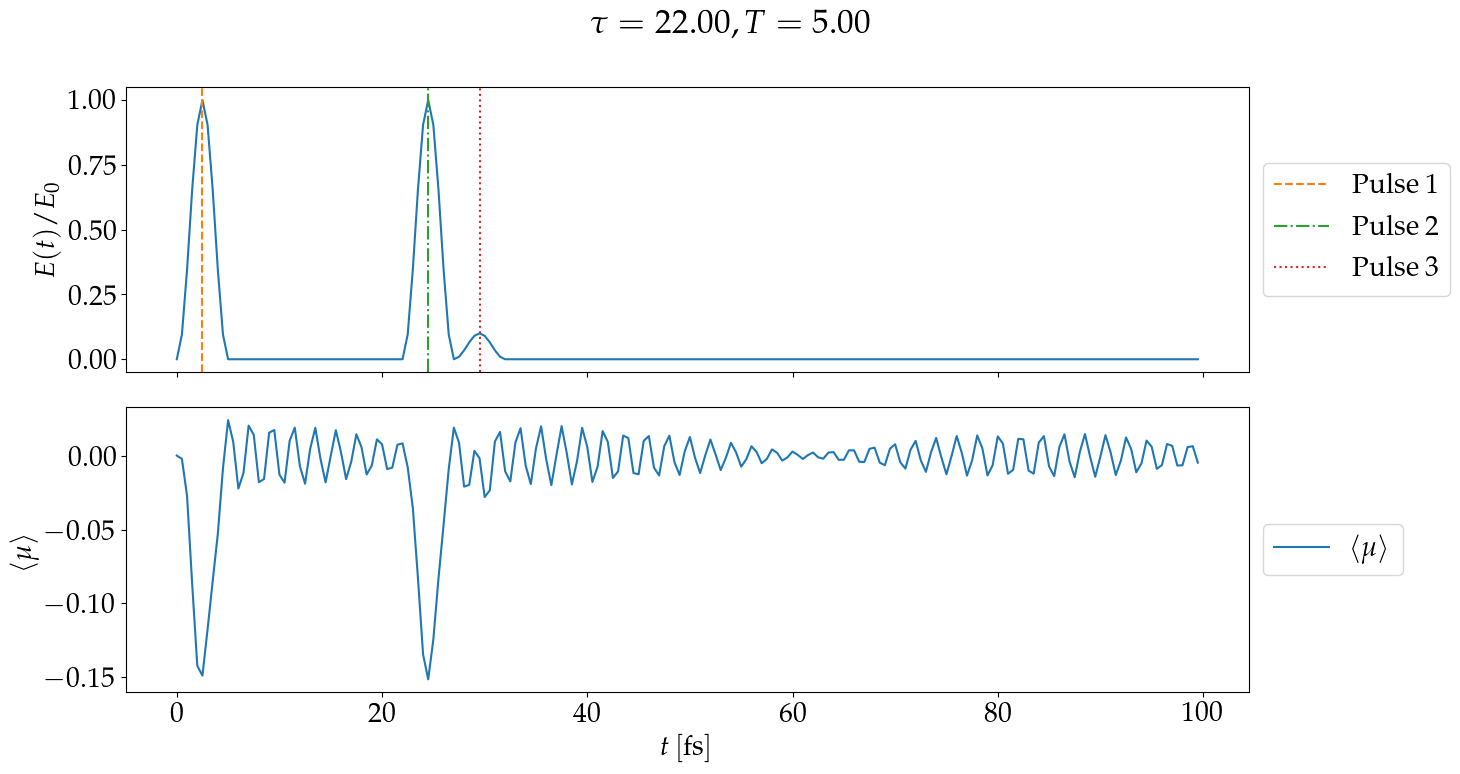

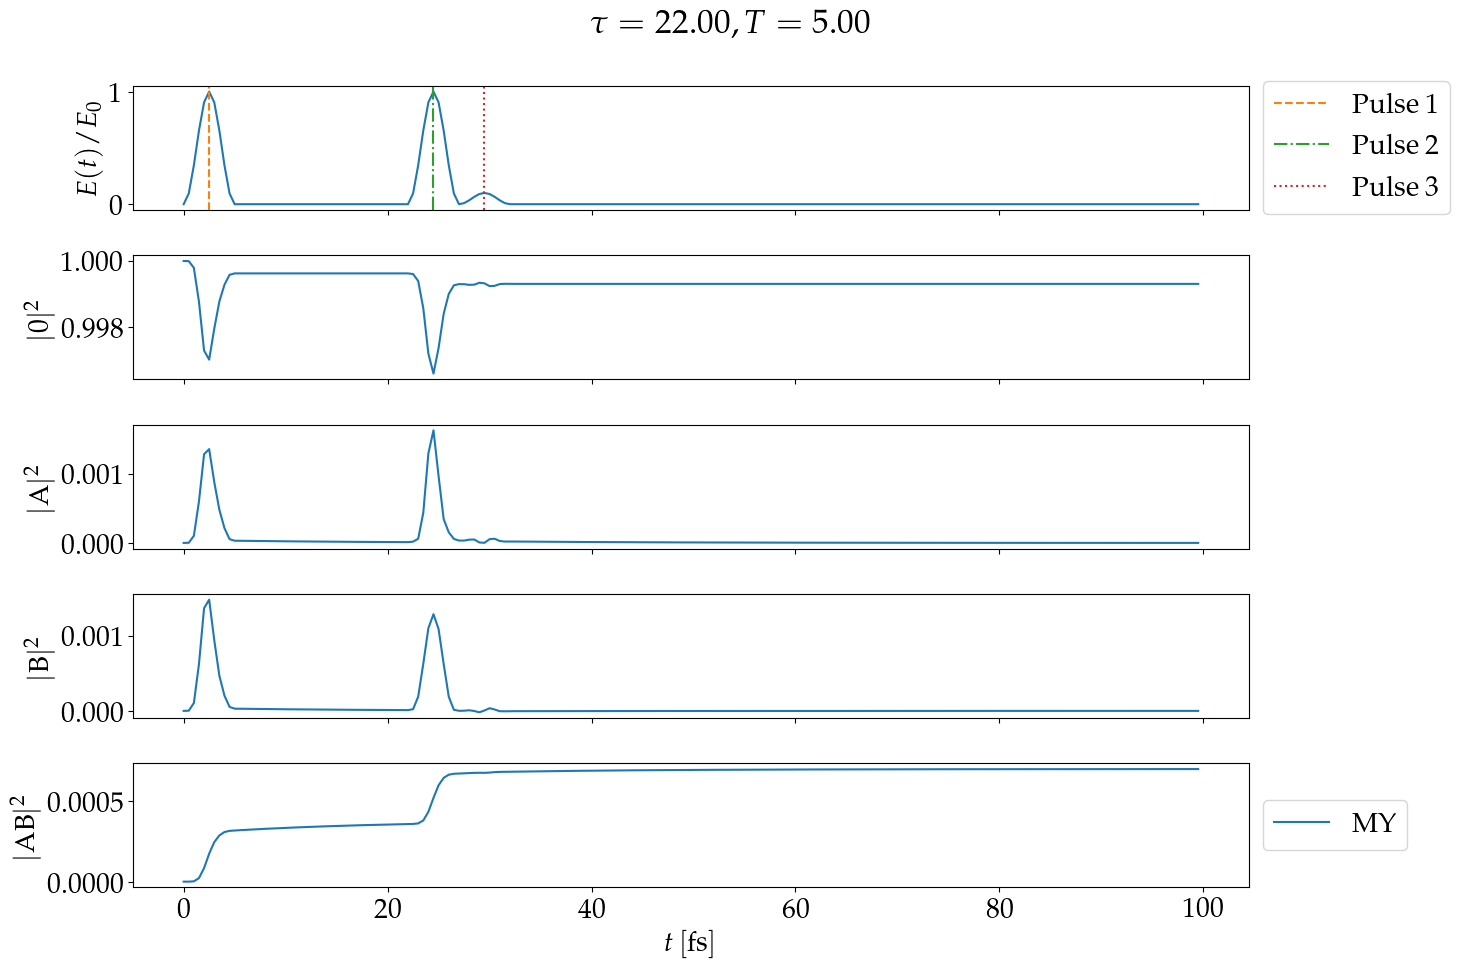

-0.0024352143538423038 -0.009949871606247175
0.0032652250923233686 0.008498982318106583
-0.003978910778855746 -0.007164819952323934
0.004582421028863443 0.0056723975705177815
-0.005066316781272249 -0.004352382647352852
0.005442934312859168 0.0029358962660838953
-0.0057091597645850005 -0.0017401121771141023
0.005882575647457041 0.0004996159081931658
-0.00596521346447692 0.00048384477696592865
0.0059784441562382735 -0.0014743211866047716
-0.005927725743811445 0.0021866500298872308
0.005836328592556093 -0.002884803667904045
-0.005711119360538417 0.0033005409242080038
0.005575221030481207 -0.0036982011649106254
-0.005434826688931889 0.0038259480930647387
0.005310897654956628 -0.003948024059625513
-0.005207037421355718 0.0038276457868404207
0.005140315256081446 -0.003727709206740582
-0.005110212238870834 0.0034244136632773006
0.005128644618625272 -0.003177467482854512
-0.005189991894972144 0.0027734868405194196
0.00530036923387418 -0.00246668474587
-0.005448752983898599 0.002051270795676548

In [24]:
first_entry = Delta_ts[1] + Delta_ts[2]
# sparse_spacing  = 10 * fine_spacing         # for waiting times T_wait
# last_entry = np.floor((t_max - (2 * Delta_ts[0] + Delta_ts[1] + Delta_ts[2])) / sparse_spacing) * sparse_spacing
# times_T = np.arange(first_entry, last_entry, sparse_spacing)
times_T = (
    np.array([0, 16, 30, 46, 62, 108, 140, 310]) + first_entry
)  # np.arange(first_entry, last_entry, sparse_spacing)

### Test Computation
T_test = times_T[0]
data_test_0 = compute_two_dimensional_polarization(T_test, phases[0], phases[0])

In [20]:
safe = False  # (**changeable**) decide if i want to save the plot to a svg file
positive = True  # (**changeable**) only plot one quadrant of the 2D-spectrum
plot_positive_color_map(
    (data_test_0[1], data_test_0[0], data_test_0[2]), T_wait=T_test, safe=safe
)
tfreqs = np.fft.fftfreq(len(data_test_0[1]), d=(data_test_0[1][1] - data_test_0[1][0]))
taufreqs = np.fft.fftfreq(
    len(data_test_0[0]), d=(data_test_0[0][1] - data_test_0[0][0])
)
plot_positive_color_map(
    (tfreqs, taufreqs, np.fft.fft2(data_test_0[2])),
    positive=positive,
    type="real",
    space="freq",
    T_wait=T_test,
    safe=safe,
)

ValueError: vmin, vcenter, and vmax must be in ascending order

In [ ]:
# RESULTS from 2D Spectroscopy with all phases and times_T, already averaged over all phi
RESULT = get_all_results(phases, times_T)

In [ ]:
# Example usage
global_time_result, global_freq_result = extend_and_plot_results(RESULT)